In [1]:
# ==============================================================================================================================
# This notebook is adapted from the kaagle's notebook of Ela Kapoor (Data Scientist)
# She built a random forest classification model to work on kaagle's dataset "art-images-drawings-painting-sculpture-engraving"
# Ela Kapoor's code : https://www.kaggle.com/code/elakapoor/art-classification-using-sklearn
# Data set : https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving
# ==============================================================================================================================

# Connect to Drive to accès dataset images directories
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 5.2 MB/s 


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path # Path module of pathlib is used to store path
import os
import glob
import cv2
import mahotas
from PIL import Image
import joblib
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

saving_path = "/content/drive/MyDrive/FS18-Luc-Fred-Nansa/1-Random-Forest"

#Choix du dataset : 
# - dataset_updated (jeu Kaggle complet : 9000 images, 8695 comptées ???)
# - Data-for-test (jeu réduit 10%), 
data_set_path = "/content/drive/MyDrive/FS18-Luc-Fred-Nansa/dataset_updated"
#data_set_path = "/content/drive/MyDrive/FS18-Luc-Fred-Nansa/Data-for-test"

global_data = Path(data_set_path+'/global_set/') 
training_data = Path(data_set_path+'/training_set/') 
validation_data = Path(data_set_path+'/validation_set/') 
shuffle_frac = 1. # To shuffle the dataset

# fix file size for feature extraction
fixed_size_ft_extract  = tuple((224, 224))

#Choose data_set for training (global_data / training_data)
data = global_data

In [ ]:
# Create a dictionary to map the labels to integers
#labels_dict= {'drawings':0, 'engraving':1, 'iconography':2, 'painting':3, 'sculpture':4}

In [ ]:
#---------------------------------------------------------------
# Construction d'un DataFrame à partir d'un dossier d'images classifiées
#---------------------------------------------------------------
def dataframe(path):
    
    # Creating an empty list to store the image name and their labels.
    df = []
    
    for folder in sorted(os.listdir(path)):
      
        # Define the path to the images
        imgs_path = path / folder
        
        # Get the list of all the images stored in that directory
        imgs = sorted(imgs_path.glob('*'))
        
        # Store each image path and corresponding label 
        for img_name in imgs:
        
            # read the image
            img = Image.open(img_name)
          
            # add image to the dataset
            df.append((os.path.basename(img_name), folder, os.path.getsize(img_name), img.width, img.height, img.mode, img.format))

    # Naming columns
    df = pd.DataFrame(df, columns=['image', 'label', 'size', 'width', 'height', 'mode', 'format'], index=None)
    
    # shuffle the dataset 
    df = df.sample(frac=shuffle_frac).reset_index(drop=True)
            
    return df

In [ ]:
#-----------------------------------------------------------------------------------------
# Chargement d'un DataFrame à partir d'un fichier csv ou d'un dossier d'images classifiées
#-----------------------------------------------------------------------------------------
def load_df(fileName_csv, path):

    # Charger le data set s'il éxiste déjà
    if os.path.isfile(fileName_csv):
        my_df = pd.read_csv(fileName_csv)
    # Sinon le reconstruire et le sauver
    else:
        my_df = dataframe(path)
        my_df.to_csv(fileName_csv, index=False)

    # Affiche le résumé du df
    display(my_df.head())
    display(my_df.describe(include='all'))

    return my_df

In [ ]:
# Loading Global data Frame
global_df = load_df(saving_path + "/global_df.csv", global_data)

,image,label,size,width,height,mode,format
0,0998.jpg,painting,17526,290,376,RGB,JPEG
1,i - 510.jpeg,sculpture,13852,180,320,RGB,JPEG
2,i - 1420.jpeg,sculpture,24510,480,282,RGB,JPEG
3,1248.jpg,painting,17526,290,376,RGB,JPEG
4,242.jpg,iconography,272536,1000,596,RGB,JPEG


,image,label,size,width,height,mode,format
count,8587,8587,8.587000e+03,8587.000000,8587.000000,8587,8587
unique,5081,5,NaN,NaN,NaN,1,2
top,i - 396.jpeg,iconography,NaN,NaN,NaN,RGB,JPEG
freq,4,2308,NaN,NaN,NaN,8587,8563
mean,NaN,NaN,4.259200e+04,355.083964,369.363573,NaN,NaN
std,NaN,NaN,8.142005e+04,150.945066,145.125762,NaN,NaN
min,NaN,NaN,1.256000e+03,37.000000,92.000000,NaN,NaN
25%,NaN,NaN,1.369800e+04,267.000000,320.000000,NaN,NaN
50%,NaN,NaN,2.057300e+04,290.000000,320.000000,NaN,NaN
75%,NaN,NaN,3.424850e+04,427.000000,370.000000,NaN,NaN


In [ ]:
# Loading Training data Frame
train_df = load_df(saving_path + "/training_df.csv", training_data)

,image,label,size,width,height,mode,format
0,155.jpg,iconography,444474,650,800,RGB,JPEG
1,701.jpg,iconography,52031,381,500,RGB,JPEG
2,i - 798.jpeg,iconography,22462,320,320,RGB,JPEG
3,603.jpg,iconography,150944,600,744,RGB,JPEG
4,233.jpg,iconography,100537,332,700,RGB,JPEG


,image,label,size,width,height,mode,format
count,7731,7731,7.731000e+03,7731.000000,7731.000000,7731,7731
unique,4756,5,NaN,NaN,NaN,1,2
top,i - 583.jpeg,iconography,NaN,NaN,NaN,RGB,JPEG
freq,4,2077,NaN,NaN,NaN,7731,7710
mean,NaN,NaN,4.300974e+04,355.902988,370.061829,NaN,NaN
std,NaN,NaN,8.232218e+04,151.464332,145.834767,NaN,NaN
min,NaN,NaN,1.256000e+03,37.000000,92.000000,NaN,NaN
25%,NaN,NaN,1.364500e+04,268.000000,320.000000,NaN,NaN
50%,NaN,NaN,2.059500e+04,290.000000,320.000000,NaN,NaN
75%,NaN,NaN,3.447550e+04,427.000000,371.000000,NaN,NaN


In [ ]:
# Loading Validation data Frame
valid_df = load_df(saving_path + "/validation_df.csv", validation_data)

,image,label,size,width,height,mode,format
0,521.jpg,iconography,127112,439,600,RGB,JPEG
1,i - 719.jpeg,iconography,20718,240,320,RGB,JPEG
2,i - 1285.jpeg,sculpture,11401,213,320,RGB,JPEG
3,1367.jpg,painting,12973,290,360,RGB,JPEG
4,i - 864.jpeg,iconography,27220,320,320,RGB,JPEG


,image,label,size,width,height,mode,format
count,856,856,8.560000e+02,856.000000,856.000000,856,856
unique,798,5,NaN,NaN,NaN,1,2
top,i - 109.jpeg,iconography,NaN,NaN,NaN,RGB,JPEG
freq,3,231,NaN,NaN,NaN,856,853
mean,NaN,NaN,3.881915e+04,347.686916,363.057243,NaN,NaN
std,NaN,NaN,7.270247e+04,146.049684,138.480383,NaN,NaN
min,NaN,NaN,4.297000e+03,141.000000,110.000000,NaN,NaN
25%,NaN,NaN,1.390900e+04,258.000000,320.000000,NaN,NaN
50%,NaN,NaN,2.037650e+04,290.000000,320.000000,NaN,NaN
75%,NaN,NaN,3.192700e+04,426.000000,365.000000,NaN,NaN


In [ ]:
# How many samples do we have in each dataset ?
print("Number of global samples: ", len(global_df))
print("Number of traininng samples: ", len(train_df))
print("Number of validation samples: ", len(valid_df))
if (len(global_df) == (len(train_df)+len(valid_df))) :
    print("GOOD : global df is exacly train df + valid df :)")
else :
    print("Warning : global df is not equal to train df + valid df !!!")

Number of global samples:  8587
Number of traininng samples:  7731
Number of validation samples:  856
GOOD : global df is exacly train df + valid df :)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


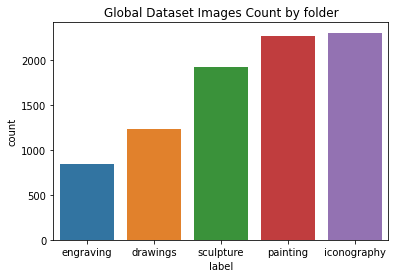

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Global Dataset Images Count by folder
sns.countplot(global_df['label'], order = global_df['label'].value_counts(ascending=True).index).set_title('Global Dataset Images Count by folder');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


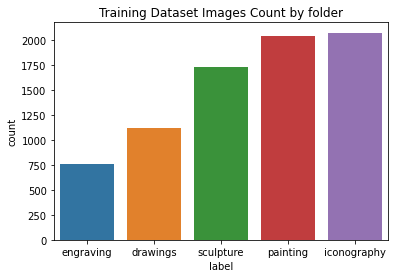

In [ ]:
# Training Dataset Images Count by folder
sns.countplot(train_df['label'], order = train_df['label'].value_counts(ascending=True).index).set_title('Training Dataset Images Count by folder');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


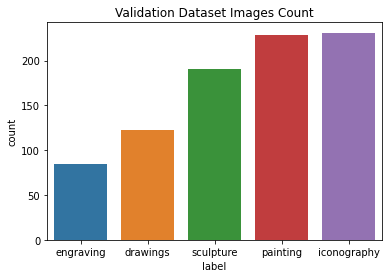

In [ ]:
# Validation Dataset Images Count by folder
sns.countplot(valid_df['label'], order = valid_df['label'].value_counts(ascending=True).index).set_title('Validation Dataset Images Count');

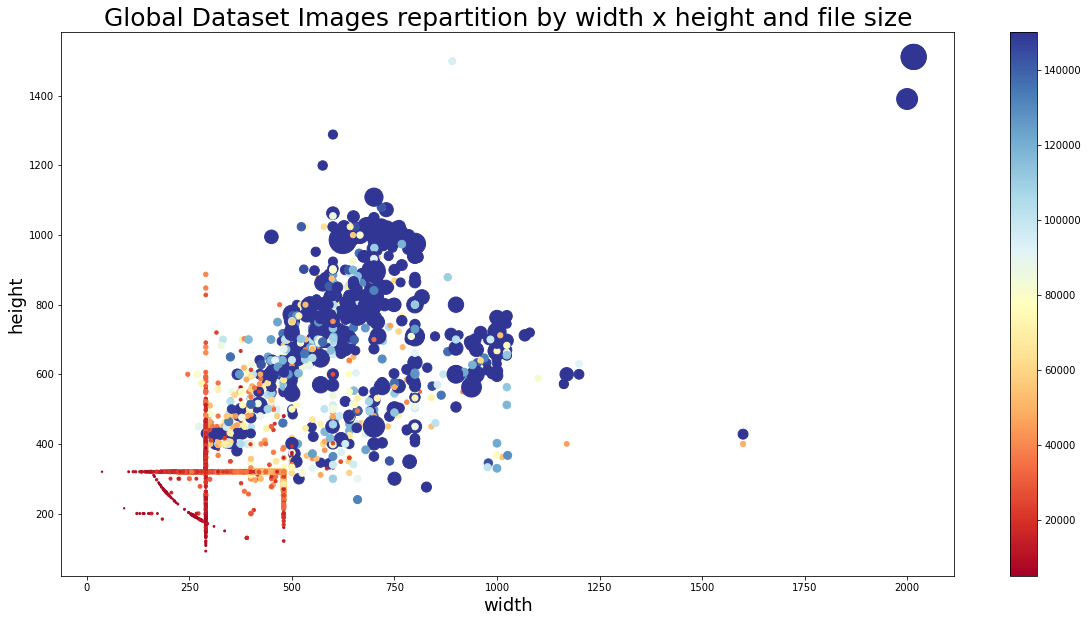

In [ ]:
# Global Dataset Images repartition by width / height and file size

figure = plt.figure(1,figsize = (20, 10))

sc = plt.scatter(train_df['width'], train_df['height'], s=train_df['size']/2000, c = train_df['size'], vmin=5000, vmax=150000, cmap=plt.cm.get_cmap('RdYlBu'))
plt.title("Global Dataset Images repartition by width x height and file size", fontsize=25) 
plt.xlabel('width', fontsize=18) 
plt.ylabel('height', fontsize=18) 
plt.colorbar(sc)

plt.show()

In [ ]:
# features description 1:  Hu Moments (7 features)
# Nb. : les Hu momments sont basés sur l"analyse des contours
def fd_hu_moments(image):
    # convert image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute the HuMoments feature 
    features = cv2.HuMoments(cv2.moments(image)).flatten()

    return features

In [ ]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# feature description 2: Haralick Texture (13 features)
# Nb. : La texture est caractérisée par la distribution spatiale des niveaux d'intensité dans un quartier.
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # Compute the haralick texture feature 
    features = mahotas.features.haralick(gray).mean(axis=0)
    
    return features

In [ ]:
# feature description 3: Color Histogram (512 features)
def fd_histogram(image, mask=None):
    # bins for histograms 
    bins = 8
    
    # conver the image to HSV colors-space
    image2 = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    #COMPUTE THE COLOR HISTOGRAM
    features  = cv2.calcHist([image2],[0,1,2],None,[bins,bins,bins], [0, 256, 0, 256, 0, 256])
    
    # normalize the histogram
    cv2.normalize(features, features)
    
    return features.flatten()

In [ ]:
# Get the data labels expect class
labels_name = os.listdir(data)

# sort the labels 
labels_name.sort()
print(labels_name)

labels_matrix = [str(idx)+"-"+x for idx, x in enumerate(labels_name)]

['drawings', 'engraving', 'iconography', 'painting', 'sculpture']


In [ ]:
def feature_extraction(labels, path):
    # empty list to hold feature vectors and labels 
    global_features = []
    labels = []
    Images = []
    
    # itirate the folder to get the image label name
    # loop over the sub folder 
    for name in labels_name:
        # join the training data path and each species training folder
        dir = os.path.join(path, name)

        # get the current training label
        current_label = name
        
        # loop over the images in each sub-folder
        for file in sorted(os.listdir(dir)):
 
            file = dir + "/" + file
 
            # read the image and resize it to a fixed-size
            image = cv2.imread(file) 
            if image is not None:
                image = cv2.resize(image,fixed_size_ft_extract)
         
                # Compute features
                fv_hu_moments = fd_hu_moments(image)
                fv_haralick   = fd_haralick(image)
                fv_histogram  = fd_histogram(image)
            
                # Update the list of Images
                Images.append(image)
                # Update the list of labels and feature vectors
                labels.append(current_label)
                # Concatenate features and update global features
                global_features.append(np.hstack([fv_histogram, fv_haralick, fv_hu_moments]))

            else:
                display("Bad image : "+file)
                
        print("Current processed folder: {}".format(current_label))

    print("Completed Global Feature Extraction...")
    
    return global_features, labels, Images

In [ ]:
# Convert images to features
global_features, labels, Images = feature_extraction(labels_name, data)

Current processed folder: drawings
Current processed folder: engraving
Current processed folder: iconography
Current processed folder: painting
Current processed folder: sculpture
Completed Global Feature Extraction...


In [ ]:
# Visualisation des features et images
display(global_features[1100])
display(labels[1100])
from google.colab.patches import cv2_imshow
cv2_imshow(Images[1100])

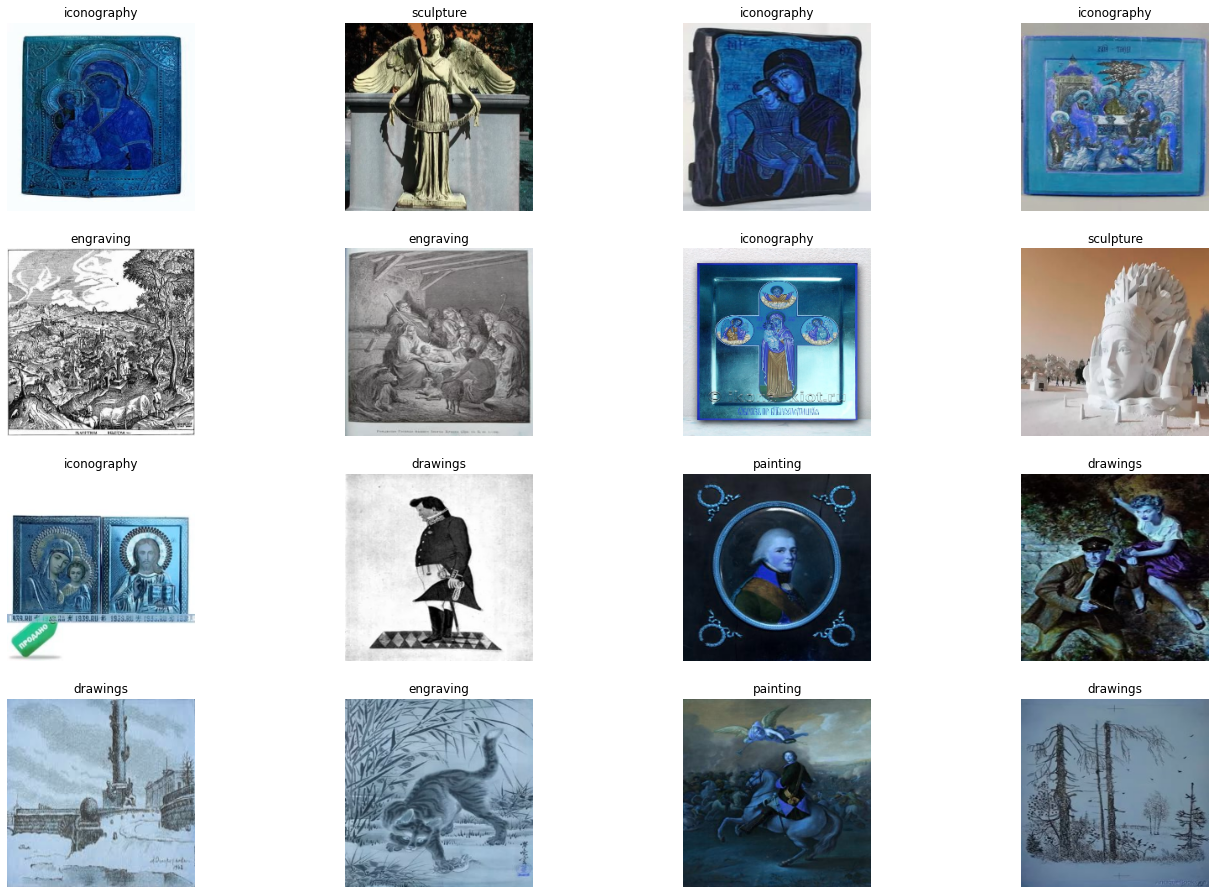

In [ ]:
from random import randint

f,ax = plt.subplots(4,4) 
f.subplots_adjust(0,0,3,3)

for i in range(0,4,1):
    for j in range(0,4,1):
        rnd_number = randint(0,len(Images))
        
        ax[i,j].imshow(Images[rnd_number])
        ax[i, j].set_title(labels[rnd_number])
        ax[i,j].axis('off')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# get the overall feature vector size
print("Training feature vector size: {}".format(np.array(global_features).shape))

# get the overall training label size
print("Training Labels: {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
print('The target names are: {}'.format(targetNames))
le = LabelEncoder()
target = le.fit_transform(labels)
print("Number of training labels encoded: {}".format(len(target)))


# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("All feature vectors are normalized.")

print("Training labels: {}".format(target))
print("Training data labels shape: {}".format(target.shape))

X = np.array(rescaled_features)
y = np.array(target)

#------------------------------
#TODO : save X and y into files
#------------------------------


Training feature vector size: (8587, 532)
Training Labels: (8587,)
The target names are: ['drawings' 'engraving' 'iconography' 'painting' 'sculpture']
Number of training labels encoded: 8587
All feature vectors are normalized.
Training labels: [0 0 0 ... 4 4 4]
Training data labels shape: (8587,)


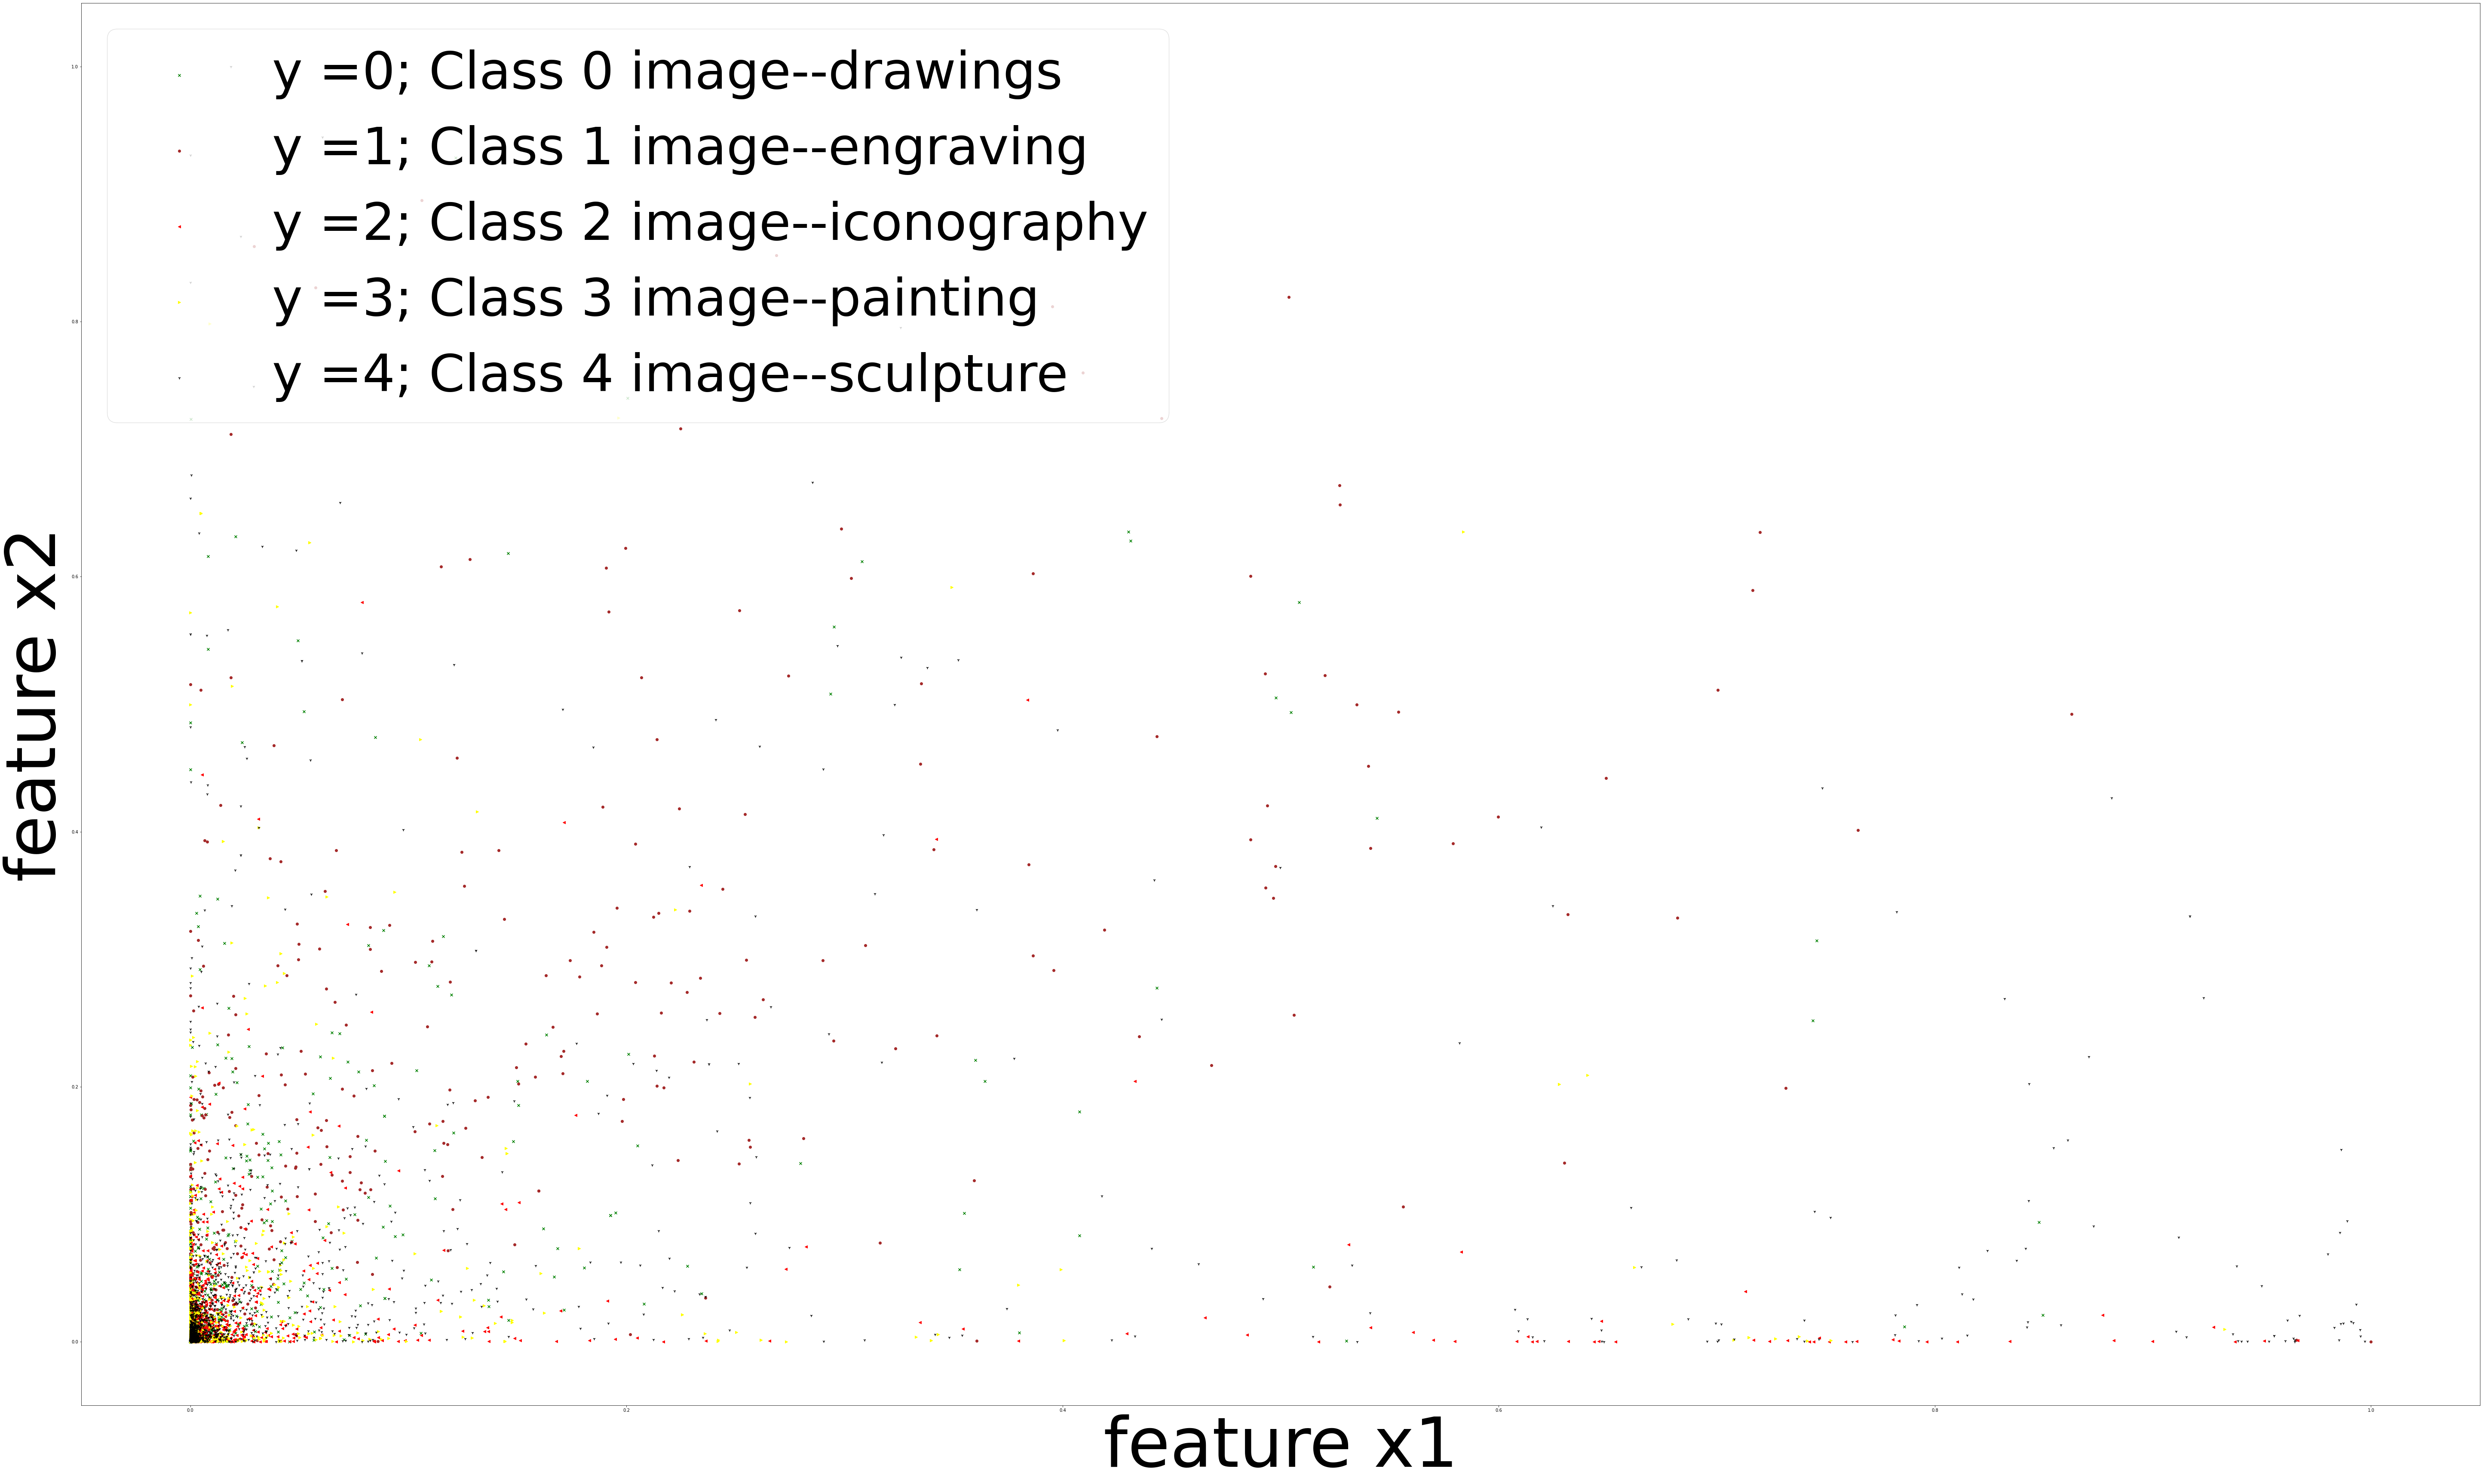

In [ ]:
# Plot scatterplot of dataset with different markings for class 0 images
idx_0 = np.where(y == 0) # indices of class 0 images
idx_1 = np.where(y == 1) # indices of class 1 images
idx_2 = np.where(y == 2) # indices of class 2 images
idx_3 = np.where(y == 3) # indices of class 3 images
idx_4 = np.where(y == 4) # indices of class 4 images
fig, axes = plt.subplots(figsize=(100, 60))
axes.scatter(X[idx_0, 0], X[idx_0, 1], c='green', marker ='x', label='y =0; Class 0 image--drawings')
axes.scatter(X[idx_1, 0], X[idx_1, 1], c='brown', marker ='o', label='y =1; Class 1 image--engraving')
axes.scatter(X[idx_2, 0], X[idx_2, 1], c='red', marker ='<', label='y =2; Class 2 image--iconography')
axes.scatter(X[idx_3, 0], X[idx_3, 1], c='yellow', marker ='>', label='y =3; Class 3 image--painting')
axes.scatter(X[idx_4, 0], X[idx_4, 1], c='black', marker ='1', label='y =4; Class 4 image--sculpture')

# Set axis labels and legend
axes.legend(loc='upper left', fontsize=120)
axes.set_xlabel('feature x1', fontsize=160)
axes.set_ylabel('feature x2', fontsize=160)

plt.savefig(saving_path+"/Features_x1_x2_by_classes.png")
plt.show()


In [ ]:
# Split dataset in train / test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

## Original Random forest model from Ela Kapoor's Notobook

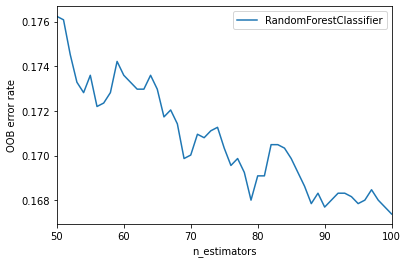

In [ ]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier

ensemble_clfs = [ ("RandomForestClassifier",RandomForestClassifier(warm_start=True, max_features=None, oob_score=True, random_state = 0))]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 50
max_estimators = 100

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))


for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
from sklearn import metrics
target_names = ['class 0: drawing', 'class 1: engraving', 'class 2: iconography', 'class 3: painting', 'class 4: sculpture']
print(metrics.classification_report(y_pred, y_test, target_names=target_names))

                      precision    recall  f1-score   support

    class 0: drawing       0.60      0.77      0.67       254
  class 1: engraving       0.73      0.81      0.77       186
class 2: iconography       0.94      0.78      0.85       668
   class 3: painting       0.90      0.97      0.94       533
  class 4: sculpture       0.88      0.85      0.86       506

            accuracy                           0.84      2147
           macro avg       0.81      0.84      0.82      2147
        weighted avg       0.86      0.84      0.85      2147



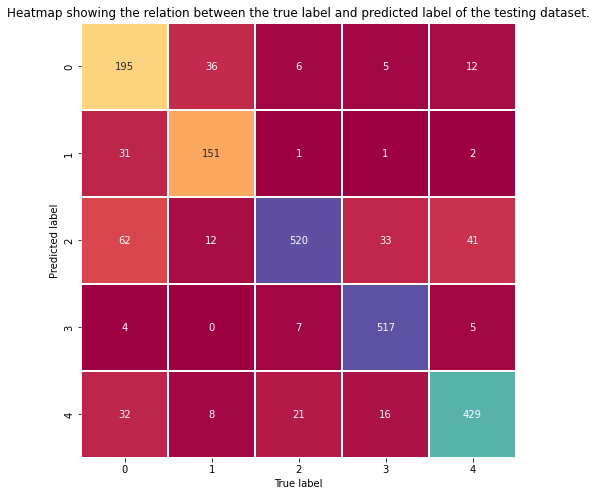

In [ ]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True,cbar = False, annot=True, fmt='d', cmap="Spectral",
            linewidths=.5)
plt.title('Heatmap showing the relation between the true label and predicted label of the testing dataset.')
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [ ]:
df = pd.DataFrame({'True Label':y_test, 'Predicted Label':y_pred})
#fig,ax = plt.plot()
ax = df.sample(40).plot(figsize=(20,10), kind = 'bar')
plt.title('Comparision of true and predicted value', fontsize=20)
plt.xlabel('Image', fontsize=18)
plt.ylabel('Label', fontsize=16)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

## Jedha's Project Decision tree
Let's train a decision tree (with hyperparameter optimization) and evaluate its performances :

### Training with hyperparameter optimization
For Decision trees, the hyperparameters that are important for overfitting are :
* min_samples_leaf
* min_samples_split
* max_depth

In what follows, we'll tune these hyperparameters with cross-validated grid search :

In [ ]:
# Perform grid search
print("Grid search...")
classifier = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 6, 8]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best validation accuracy :  0.7411561400864713


In [ ]:
# Save the model : DecisionTree_final_model
joblib.dump(gridsearch, saving_path + '/DecisionTree_final_model.joblib2')

['/content/drive/MyDrive/FS18-Luc-Fred-Nansa/1-Random-Forest/DecisionTree_final_model.joblib2']

In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[2 3 2 ... 4 3 4]

Predictions on test set...
...Done.
[3 4 3 ... 2 4 3]



In [ ]:
# Accuracy socre
print("accuracy on training set : ", accuracy_score(y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(y_test, Y_test_pred))
print()

accuracy on training set :  0.8685398165671859
accuracy on test set :  0.7724097788125728



In [ ]:
# View the classification report for training data and predictions
print("-------------------------------------------------------")
print("classification report for TRAINING data and predictions")
print("-------------------------------------------------------")
print(classification_report(y_train, Y_train_pred))
print("F1 Score micro : "+str(f1_score(y_train, Y_train_pred, average='micro')))
print("F1 Score macro : "+str(f1_score(y_train, Y_train_pred, average='macro')))
print()

# View the classification report for test data and predictions
print("---------------------------------------------------")
print("classification report for TEST data and predictions")
print("---------------------------------------------------")
print(classification_report(y_test, Y_test_pred))
print(f"F1 Score micro : "+str(f1_score(y_test, Y_test_pred, average='micro')))
print(f"F1 Score macro : "+str(f1_score(y_test, Y_test_pred, average='macro')))
print()

classification report for training data and predictions
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       991
           1       0.80      0.73      0.76       673
           2       0.85      0.92      0.89      1846
           3       0.95      0.93      0.94      1816
           4       0.89      0.91      0.90      1543

    accuracy                           0.87      6869
   macro avg       0.85      0.84      0.84      6869
weighted avg       0.87      0.87      0.87      6869


classification report for test data and predictions
---------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.54      0.56       248
           1       0.72      0.64      0.68       168
           2       0.76      0.81      0.79       462
           3       0.89      0.89      0.89       454
           4       0.78

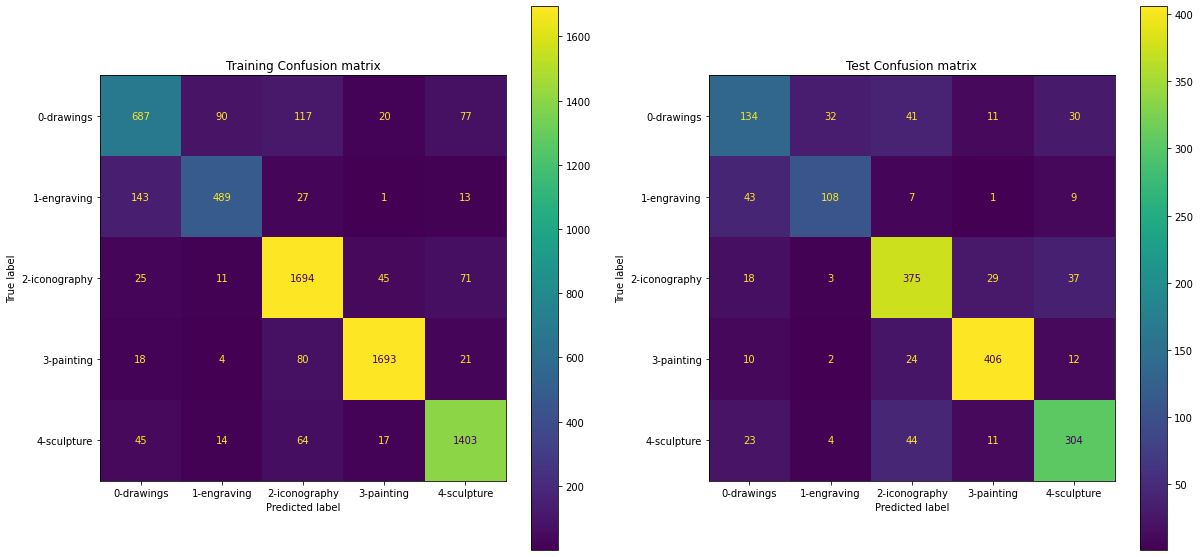

In [ ]:
# Display Training and Test confusion matrix
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, display_labels=labels_matrix, ax=ax[0])
ax[0].title.set_text("Training Confusion matrix")
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, display_labels=labels_matrix, ax=ax[1])
ax[1].title.set_text("Test Confusion matrix")

## Random Forest
Let's train a Random Forest (with hyperparameter optimization) and evaluate its performances :

### Training with hyperparameter optimization
For Random Forest, the hyperparameters that are important for overfitting are :
* min_samples_leaf
* min_samples_split
* max_depth
* n_estimators

In what follows, you'll see an example of how to tune these hyperparameters with cross-validated grid search :

In [ ]:
# Perform grid search
print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 40, 100]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
Best validation accuracy :  0.8119104533230569


In [ ]:
# Save the model : RandomForest_final_model
joblib.dump(gridsearch, saving_path + '/RandomForest_final_model.joblib2')

['/content/drive/MyDrive/FS18-Luc-Fred-Nansa/1-Random-Forest/RandomForest_final_model.joblib2']

In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[2 2 2 ... 4 3 4]

Predictions on test set...
...Done.
[3 4 3 ... 2 4 3]



In [ ]:
# View the classification report for training data and predictions
print("-------------------------------------------------------")
print("classification report for TRAINING data and predictions")
print("-------------------------------------------------------")
print(classification_report(y_train, Y_train_pred))
print("Accuracy : ", accuracy_score(y_train, Y_train_pred))
print("F1 Score micro : "+str(f1_score(y_train, Y_train_pred, average='micro')))
print("F1 Score macro : "+str(f1_score(y_train, Y_train_pred, average='macro')))
print("(F1 Score worst : "+str(f1_score(y_train, [4 for i in range(len(y_train))], average='macro'))+")")

print()

# View the classification report for test data and predictions
print("---------------------------------------------------")
print("classification report for TEST data and predictions")
print("---------------------------------------------------")
print(classification_report(y_test, Y_test_pred))
print("accuracy : ", accuracy_score(y_test, Y_test_pred))
print(f"F1 Score micro : "+str(f1_score(y_test, Y_test_pred, average='micro')))
print(f"F1 Score macro : "+str(f1_score(y_test, Y_test_pred, average='macro')))
print("(F1 Score worst : "+str(f1_score(y_test, [0 for i in range(len(y_test))], average='macro'))+")")
print()

-------------------------------------------------------
classification report for TRAINING data and predictions
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       991
           1       0.88      0.80      0.84       673
           2       0.87      0.98      0.92      1846
           3       0.99      0.95      0.97      1816
           4       0.94      0.95      0.95      1543

    accuracy                           0.92      6869
   macro avg       0.91      0.89      0.90      6869
weighted avg       0.92      0.92      0.92      6869

Accuracy :  0.9174552336584656
F1 Score micro : 0.9174552336584656
F1 Score macro : 0.8980920809255599
(F1 Score worst : 0.07337137422729434)

---------------------------------------------------
classification report for TEST data and predictions
---------------------------------------------------
              precision    recall  f1-score 

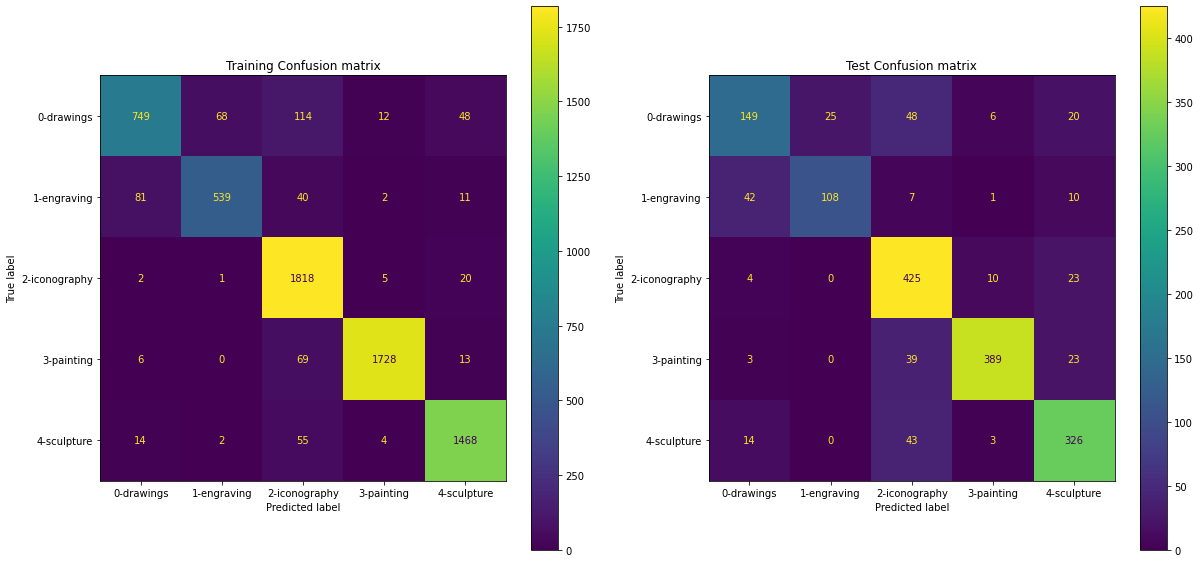

In [ ]:
# Display Training and Test confusion matrix
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, display_labels=labels_matrix, ax=ax[0])
ax[0].title.set_text("Training Confusion matrix")
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, display_labels=labels_matrix, ax=ax[1])
ax[1].title.set_text("Test Confusion matrix")

In [ ]:
#labels_dict = {'drawings':0, 'engraving':1, 'iconography':2, 'painting':3, 'sculpture':4}
#majors = {'iconography':2, 'painting':3}
import 
y_true = [0,1,2,3,4]
y_pred = [0,0,0,0,0]
print (f1_score(y_true, y_pred))

print
y_true = train_df['label']
y_pred = ['']